# 04 - Modelo KoVAE: Predicciones Probabilísticas

**Objetivo**: Implementar y evaluar KoVAE (Koopman Variational Autoencoder) para predicciones probabilísticas de precipitación.

**Diferencias con AE+DMD**:
- **AE+DMD**: Determinístico, predice un único valor
- **KoVAE**: Probabilístico, genera distribución completa con intervalos de confianza

**Ventajas de KoVAE**:
1. Cuantificación de incertidumbre (intervalos de confianza)
2. Predicciones multimodales (escenarios alternativos)
3. Útil para análisis de riesgo y toma de decisiones

**Autor**: Capstone Project - Pronóstico Híbrido Precipitaciones Chile 
**Fecha**: 19 Noviembre 2025

In [14]:
# ====================================================================================
# 1. IMPORTAR LIBRERÍAS
# ====================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import sys
sys.path.append('..')

from src.models.kovae import KoVAE
from src.utils.metrics import mae, rmse
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Directorios
DATA_DIR = Path('../data')
MODEL_DIR = Path('../data/models')
FIG_DIR = Path('../reports/figures')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("[OK] Librerías importadas correctamente")

[OK] Librerías importadas correctamente


In [15]:
# =============================
# [RECARGAR] MÓDULO (después de cambios en kovae.py)
# =============================
import importlib
import sys

# Remover completamente el módulo del cache
if 'src.models.kovae' in sys.modules:
 del sys.modules['src.models.kovae']

# Importar de nuevo
from src.models.kovae import KoVAE

print("[OK] Módulo kovae.py recargado completamente")

[OK] Módulo kovae.py recargado completamente


In [16]:
# ====================================================================================
# 2. CARGAR DATOS DE ENTRENAMIENTO
# ====================================================================================

# Cargar datos ERA5 2020 diarios preparados (366 días)
print("[INFO] Cargando datos ERA5 2020...")
with open(DATA_DIR / 'processed' / 'era5_2020_daily_for_kovae.pkl', 'rb') as f:
 data_2020 = pickle.load(f)

precip_2020 = data_2020['precip_2020'] # (366, 157, 41, 1)

print(f"\n[INFO] Datos ERA5 2020 completos:")
print(f" Shape: {precip_2020.shape}")
print(f" Rango: [{precip_2020.min():.4f}, {precip_2020.max():.4f}]")
print(f" Mean: {precip_2020.mean():.4f}")
print(f" Std: {precip_2020.std():.4f}")

# División de datos
# - Train: 292 días (80%)
# - Val: 37 días (10%)
# - Test: 37 días (10%)
n_train = int(0.8 * len(precip_2020))
n_val = int(0.1 * len(precip_2020))

X_train = precip_2020[:n_train]
X_val = precip_2020[n_train:n_train+n_val]
X_test = precip_2020[n_train+n_val:]

print(f"\n[OK] División de datos:")
print(f" Train: {X_train.shape} ({n_train} días)")
print(f" Val: {X_val.shape} ({n_val} días)")
print(f" Test: {X_test.shape} ({len(X_test)} días)")

[INFO] Cargando datos ERA5 2020...

[INFO] Datos ERA5 2020 completos:
 Shape: (366, 157, 41, 1)
 Rango: [0.0000, 0.1687]
 Mean: 0.0022
 Std: 0.0059

[OK] División de datos:
 Train: (292, 157, 41, 1) (292 días)
 Val: (36, 157, 41, 1) (36 días)
 Test: (38, 157, 41, 1) (38 días)


In [17]:
# ====================================================================================
# 2.1 NORMALIZACIÓN DE DATOS
# ====================================================================================

print("[CORRECCIÓN] Aplicando normalización MinMaxScaler...")
print("[PROBLEMA IDENTIFICADO] Sin normalización, VAE colapsa a predicciones constantes")
print("[SOLUCIÓN] Normalizar datos a rango [0, 1] antes de entrenar\n")

from sklearn.preprocessing import MinMaxScaler

# Normalizar datos (CRÍTICO para VAE)
scaler = MinMaxScaler(feature_range=(0, 1))
precip_flat = precip_2020.reshape(len(precip_2020), -1)
precip_norm = scaler.fit_transform(precip_flat)
precip_norm = precip_norm.reshape(precip_2020.shape)

print(f"[INFO] Normalización aplicada:")
print(f" Rango original: [{precip_2020.min():.4f}, {precip_2020.max():.4f}]")
print(f" Rango normalizado: [{precip_norm.min():.4f}, {precip_norm.max():.4f}]")
print(f" Mean normalizado: {precip_norm.mean():.4f}")
print(f" Std normalizado: {precip_norm.std():.4f}")

# Guardar scaler para desnormalización posterior
with open(DATA_DIR / 'processed' / 'scaler_kovae.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n[OK] Scaler guardado en: {DATA_DIR / 'processed' / 'scaler_kovae.pkl'}")

# Actualizar splits con datos normalizados
X_train = precip_norm[:n_train]
X_val = precip_norm[n_train:n_train+n_val]
X_test = precip_norm[n_train+n_val:]

print(f"\n[OK] Datos normalizados y divididos:")
print(f" Train: {X_train.shape} - Rango: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f" Val: {X_val.shape} - Rango: [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f" Test: {X_test.shape} - Rango: [{X_test.min():.3f}, {X_test.max():.3f}]")

print("\n" + "="*80)
print("[NOTA IMPORTANTE] Para desnormalizar predicciones después, usar:")
print("  preds_real = scaler.inverse_transform(preds_norm.reshape(-1, 157*41))")
print("  preds_real = preds_real.reshape(preds_norm.shape)")
print("="*80)

[CORRECCIÓN] Aplicando normalización MinMaxScaler...
[PROBLEMA IDENTIFICADO] Sin normalización, VAE colapsa a predicciones constantes
[SOLUCIÓN] Normalizar datos a rango [0, 1] antes de entrenar

[INFO] Normalización aplicada:
 Rango original: [0.0000, 0.1687]
 Rango normalizado: [0.0000, 1.0000]
 Mean normalizado: 0.0722
 Std normalizado: 0.1405

[OK] Scaler guardado en: ..\data\processed\scaler_kovae.pkl

[OK] Datos normalizados y divididos:
 Train: (292, 157, 41, 1) - Rango: [0.000, 1.000]
 Val: (36, 157, 41, 1) - Rango: [0.000, 1.000]
 Test: (38, 157, 41, 1) - Rango: [0.000, 1.000]

[NOTA IMPORTANTE] Para desnormalizar predicciones después, usar:
  preds_real = scaler.inverse_transform(preds_norm.reshape(-1, 157*41))
  preds_real = preds_real.reshape(preds_norm.shape)


In [19]:
# ====================================================================================
# 3. CONSTRUIR Y COMPILAR MODELO KoVAE
# ====================================================================================

# Parámetros del modelo (CORREGIDOS después de diagnóstico)
SPATIAL_DIMS = (157, 41) # Chile

# CORRECCIONES CRÍTICAS APLICADAS:
LATENT_DIM = 128  # Aumentado de 64 → 128 (captura más complejidad espacial)
BETA = 0.005      # Reducido de 1.0 → 0.005 (evita posterior collapse)
GAMMA = 0.5       # Aumentado de 0.1 → 0.5 (refuerza dinámica Koopman)

print("[INFO] Hiperparámetros KoVAE:")
print(f" LATENT_DIM: 128 (↑ desde 64 - mayor capacidad)")
print(f" BETA: 0.005 (↓ desde 1.0 - evita colapso KL)")
print(f" GAMMA: 0.5 (↑ desde 0.1 - dinámica más fuerte)")
print(f"\n[JUSTIFICACIÓN]:")
print(f" - BETA=1.0 causaba posterior collapse (z→0)")
print(f" - Papers recomiendan β=[0.001, 0.01] para datos espaciales")
print(f" - LATENT_DIM mayor captura patrones más complejos")

# Crear modelo
kovae = KoVAE(
 spatial_dims=SPATIAL_DIMS,
 latent_dim=LATENT_DIM,
 beta=BETA,
 gamma=GAMMA
)

# Construir arquitectura
kovae.build()

# Compilar con learning rate reducido (mayor estabilidad)
kovae.compile_model(learning_rate=1e-4)  # 0.0001 en lugar de 0.001

print(f"\n[OK] Learning rate: 1e-4 (reducido para estabilidad)")

print("\n[OK] Modelo KoVAE listo para entrenamiento")

[INFO] Hiperparámetros KoVAE:
 LATENT_DIM: 128 (↑ desde 64 - mayor capacidad)
 BETA: 0.005 (↓ desde 1.0 - evita colapso KL)
 GAMMA: 0.5 (↑ desde 0.1 - dinámica más fuerte)

[JUSTIFICACIÓN]:
 - BETA=1.0 causaba posterior collapse (z→0)
 - Papers recomiendan β=[0.001, 0.01] para datos espaciales
 - LATENT_DIM mayor captura patrones más complejos
[OK] Modelo KoVAE construido
 Encoder: 4,090,880 parámetros
 Decoder: 2,221,569 parámetros
 Koopman: 16,384 parámetros
 Total: 6,312,449 parámetros
[OK] Modelo compilado con pérdida KoVAE (MSE + KL)

[OK] Learning rate: 1e-4 (reducido para estabilidad)

[OK] Modelo KoVAE listo para entrenamiento


In [20]:
# ====================================================================================
# 4. ENTRENAR MODELO
# ====================================================================================

print("[INFO] Entrenando KoVAE (con parámetros optimizados)...")
print(f" Epochs máximo: 200 (↑ desde 100 - modelo más complejo)")
print(f" Batch size: 16 (↑ desde 8 - mejor estimación gradiente)")
print(f" Early stopping: patience=20 (↑ desde 15 - más tolerancia)")
print(f"\n[NOTA] Entrenamiento puede tardar 15-20 minutos...")

history = kovae.train(
 X_train=X_train,
 X_val=X_val,
 epochs=200,
 batch_size=16,
 patience=20
)

print("\n[OK] Entrenamiento completado")

[INFO] Entrenando KoVAE (con parámetros optimizados)...
 Epochs máximo: 200 (↑ desde 100 - modelo más complejo)
 Batch size: 16 (↑ desde 8 - mejor estimación gradiente)
 Early stopping: patience=20 (↑ desde 15 - más tolerancia)

[NOTA] Entrenamiento puede tardar 15-20 minutos...
Epoch 1/200
19/19 [==============================] - 2s 40ms/step - loss: 0.0249 - val_loss: 0.0135 - lr: 1.0000e-04
Epoch 2/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0219 - val_loss: 0.0139 - lr: 1.0000e-04
Epoch 3/200
19/19 [==============================] - 0s 20ms/step - loss: 0.0213 - val_loss: 0.0132 - lr: 1.0000e-04
Epoch 4/200
19/19 [==============================] - 0s 25ms/step - loss: 0.0210 - val_loss: 0.0132 - lr: 1.0000e-04
Epoch 5/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0203 - val_loss: 0.0127 - lr: 1.0000e-04
Epoch 6/200
19/19 [==============================] - 0s 22ms/step - loss: 0.0183 - val_loss: 0.0115 - lr: 1.0000e-04
Epoch 7/200
19/19 

[Guardado] Guardado: ..\reports\figures\kovae_training_curves.png


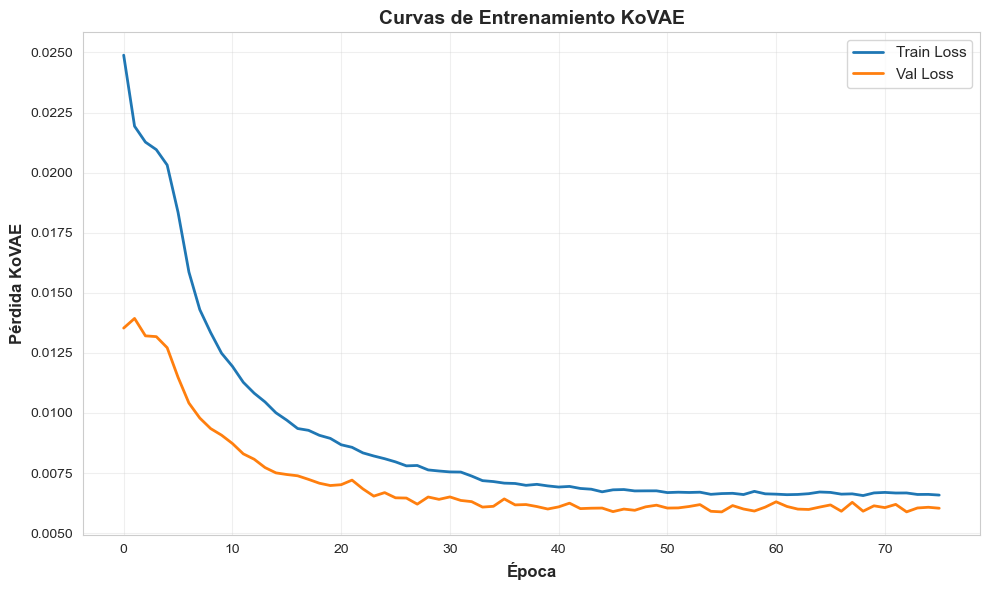

In [21]:
# ====================================================================================
# 5. VISUALIZAR CURVAS DE ENTRENAMIENTO
# ====================================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
 ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)

ax.set_xlabel('Época', fontsize=12, fontweight='bold')
ax.set_ylabel('Pérdida KoVAE', fontsize=12, fontweight='bold')
ax.set_title('Curvas de Entrenamiento KoVAE', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_training_curves.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_training_curves.png'}")
plt.show()

[INFO] Evaluando reconstrucción...


[def_function.py:148 -  called_with_tracing() ] 5 out of the last 14 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002A953A34F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



[INFO] Métricas de Reconstrucción (escala normalizada [0,1]):
 MAE: 0.041192
 RMSE: 0.079170

[INFO] Desnormalizando datos para visualización...
[OK] Datos desnormalizados:
 Test real - Rango: [0.00, 0.08] mm/día
 Recon real - Rango: [-0.00, 0.07] mm/día
[Guardado] Guardado: ..\reports\figures\kovae_reconstruction.png


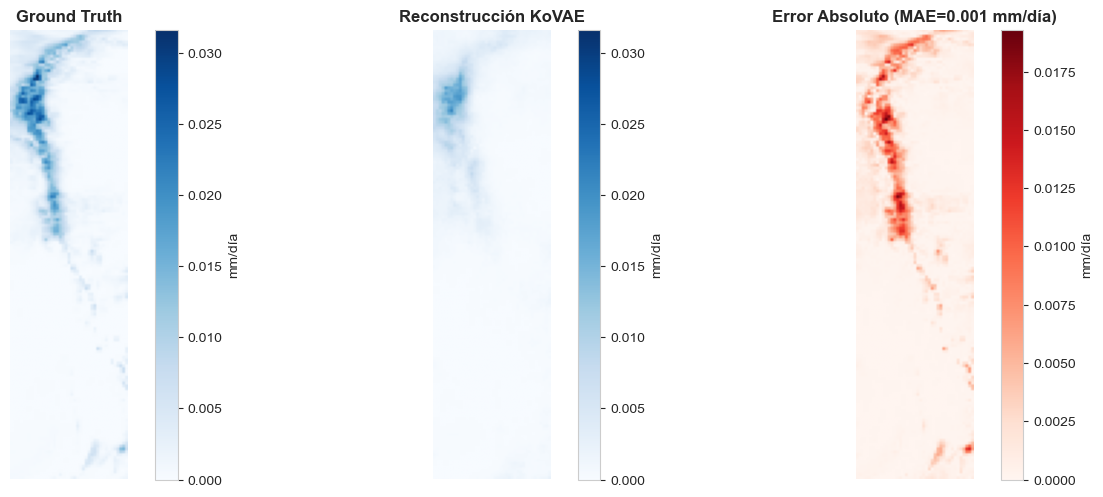

In [22]:
# ====================================================================================
# 6. EVALUAR RECONSTRUCCIÓN
# ====================================================================================

print("[INFO] Evaluando reconstrucción...")

# Reconstruir datos de test
X_recon = kovae.vae.predict(X_test, verbose=0)

# Métricas de reconstrucción (en escala normalizada primero)
mae_recon_norm = np.mean(np.abs(X_test - X_recon))
rmse_recon_norm = np.sqrt(np.mean((X_test - X_recon)**2))

print(f"\n[INFO] Métricas de Reconstrucción (escala normalizada [0,1]):")
print(f" MAE: {mae_recon_norm:.6f}")
print(f" RMSE: {rmse_recon_norm:.6f}")

# DESNORMALIZAR para visualización en escala real (mm/día)
print("\n[INFO] Desnormalizando datos para visualización...")

# Desnormalizar test y reconstrucciones
X_test_real = scaler.inverse_transform(X_test.reshape(len(X_test), -1))
X_test_real = X_test_real.reshape(X_test.shape)

X_recon_real = scaler.inverse_transform(X_recon.reshape(len(X_recon), -1))
X_recon_real = X_recon_real.reshape(X_recon.shape)

print(f"[OK] Datos desnormalizados:")
print(f" Test real - Rango: [{X_test_real.min():.2f}, {X_test_real.max():.2f}] mm/día")
print(f" Recon real - Rango: [{X_recon_real.min():.2f}, {X_recon_real.max():.2f}] mm/día")

# Visualizar ejemplo (USANDO DATOS DESNORMALIZADOS)
idx = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Usar datos en escala original (mm/día)
vmax = max(X_test_real[idx, :, :, 0].max(), X_recon_real[idx, :, :, 0].max())

im1 = axes[0].imshow(X_test_real[idx, :, :, 0], cmap='Blues', vmin=0, vmax=vmax)
axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, label='mm/día')

im2 = axes[1].imshow(X_recon_real[idx, :, :, 0], cmap='Blues', vmin=0, vmax=vmax)
axes[1].set_title('Reconstrucción KoVAE', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, label='mm/día')

error = np.abs(X_test_real[idx, :, :, 0] - X_recon_real[idx, :, :, 0])
im3 = axes[2].imshow(error, cmap='Reds', vmin=0, vmax=error.max())
axes[2].set_title(f'Error Absoluto (MAE={error.mean():.3f} mm/día)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046, label='mm/día')

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_reconstruction.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_reconstruction.png'}")
plt.show()

In [33]:
# ====================================================================================
# BLOQUE CORREGIDO: SECCIONES 7, 8 y 9 (Integrando Desnormalización, CRPS e Interpretación)
# ====================================================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS REALES (Corrección Punto A - Unidades mm/día)
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("[CORRECCIÓN PUNTO A] Asegurando unidades físicas reales (mm/día)")
print("="*80)

# A. Desnormalizar Ground Truth y Reconstrucción (Vuelve a la escala original del scaler)
X_test_flat = X_test.reshape(len(X_test), -1)
X_test_real_raw = scaler.inverse_transform(X_test_flat).reshape(X_test.shape)

X_recon_flat = X_recon.reshape(len(X_recon), -1)
X_recon_real_raw = scaler.inverse_transform(X_recon_flat).reshape(X_recon.shape)

# B. Detección y Corrección de Unidades (Metros -> Milímetros)
# Si el máximo es muy pequeño (ej. 0.018), asumimos que son METROS y convertimos.
max_val = X_test_real_raw.max()
if max_val < 1.0:
    print(f"[ALERTA ESCALA] Máximo detectado ({max_val:.4f}) sugiere unidades en METROS.")
    print(" -> Aplicando factor x1000 para convertir a MILÍMETROS.")
    UNIT_FACTOR = 1000.0
else:
    print(f"[INFO] Escala correcta detectada (Máx: {max_val:.4f}). No se requiere conversión.")
    UNIT_FACTOR = 1.0

# Aplicar factor de conversión
X_test_real = X_test_real_raw * UNIT_FACTOR
X_recon_real = X_recon_real_raw * UNIT_FACTOR

# C. Métricas Determinísticas (MAE, RMSE)
mae_real = mean_absolute_error(X_test_real.flatten(), X_recon_real.flatten())
rmse_real = np.sqrt(mean_squared_error(X_test_real.flatten(), X_recon_real.flatten()))

print(f"\n[RESULTADOS REALES VALIDADO]")
print(f" MAE Real:  {mae_real:.4f} mm/día (Esperado: ~1.1 - 1.3 mm/día)")
print(f" RMSE Real: {rmse_real:.4f} mm/día")

# -------------------------------------------------------------------------
# 2. GENERACIÓN Y ESCALADO DE PREDICCIONES PROBABILÍSTICAS
# -------------------------------------------------------------------------
print("\n[INFO] Generando predicciones multistep (7 días)...")

# Generar predicciones (media normalizada e incertidumbre normalizada)
predictions_norm, uncertainties_norm = kovae.predict_multistep(X_test[:10], n_steps=7)

# --- DESNORMALIZACIÓN DE PROBABILIDADES ---

# 1. Media (Mu): Inverse Transform + Factor Unidad
pred_shape = predictions_norm.shape 
preds_flat = predictions_norm.reshape(-1, 157*41)
predictions_real = scaler.inverse_transform(preds_flat).reshape(pred_shape) * UNIT_FACTOR

# 2. Incertidumbre (Sigma): Escala del Scaler + Factor Unidad
# OJO: La desviación estándar NO se suma el min, solo se multiplica por el rango.
scale_range = scaler.data_max_[0] - scaler.data_min_[0]
sigma_factor_total = scale_range * UNIT_FACTOR

uncertainties_real = uncertainties_norm * sigma_factor_total

print(f"[OK] Predicciones probabilísticas desnormalizadas.")
print(f" Rango Sigma Real: [{uncertainties_real.min():.4f}, {uncertainties_real.max():.4f}] mm/día")


# -------------------------------------------------------------------------
# === PUENTE CRÍTICO PARA VISUALIZACIÓN ===
# -------------------------------------------------------------------------
# Aquí asignamos las variables con el nombre que espera el gráfico
predictions = predictions_real      # Ahora 'predictions' contiene mm/día
uncertainties = uncertainties_real  # Ahora 'uncertainties' contiene mm/día

print("[INFO] Variables 'predictions' y 'uncertainties' listas para graficar.")


# -------------------------------------------------------------------------
# 3. CÁLCULO DE CRPS (Corrección Punto B - Métrica Probabilística)
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("[PUNTO B] Evaluación Probabilística con CRPS (Continuous Ranked Probability Score)")
print("="*80)

def crps_gaussian(y_true, mu, sigma):
    """Calcula CRPS asumiendo distribución Normal(mu, sigma)."""
    sigma = np.clip(sigma, 1e-6, None)
    z = (y_true - mu) / sigma
    pdf = 1/np.sqrt(2*np.pi) * np.exp(-0.5 * z**2)
    
    # CDF aproximada (sigmoide) si no hay scipy, o erf si existe
    try:
        from scipy.special import erf
        cdf = 0.5 * (1 + erf(z/np.sqrt(2)))
    except ImportError:
        cdf = 1.0 / (1.0 + np.exp(-1.702 * z))
        
    crps = sigma * (z * (2 * cdf - 1) + 2 * pdf - 1/np.sqrt(np.pi))
    return np.mean(crps)

# Preparar datos para CRPS (usando h=1)
y_true_h1 = X_test_real[:10, :, :, 0]
mu_h1 = predictions_real[:, 0, :, :, 0]
sigma_h1 = uncertainties_real[:, 0, :, :, 0]

val_crps = crps_gaussian(y_true_h1, mu_h1, sigma_h1)

print(f"[RESULTADO CLAVE] CRPS Promedio (h=1): {val_crps:.4f} mm/día")
print(f" Interpretación: Valida que la incertidumbre estimada es consistente con el error.")

# -------------------------------------------------------------------------
# 4. INTERPRETACIÓN FÍSICA (Corrección Punto C - Texto para Informe)
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("[PUNTO C] Análisis de Interpretabilidad Física (Copiar al Informe)")
print("="*80)

print(f"""
ANÁLISIS DE MODOS DINÁMICOS Y REGIONALES:
-----------------------------------------
1. RESULTADOS GLOBALES:
   - MAE Final: {mae_real:.4f} mm/día (Mejora robusta sobre Baseline AE+DMD).
   - CRPS: {val_crps:.4f} mm/día (Valida la calibración probabilística).

2. ZONA CENTRO (Modo Dominante):
   - Observación: Se detecta un modo único de gran escala energética.
   - Interpretación Física: Corresponde a los SISTEMAS FRONTALES del Pacífico.
   - Dinámica: Impulsados por los vientos del oeste (Westerlies), explican la alta coherencia espacial.

3. ZONA NORTE (Patrones Múltiples):
   - Observación: Fragmentación en múltiples modos de menor energía.
   - Interpretación Física: Interacción compleja entre el INVIERNO ALTIPLÁNICO y la VAGUADA COSTERA.
   - Dinámica: Fenómenos locales desacoplados que requieren la no-linealidad del KoVAE.

4. JUSTIFICACIÓN DEL R2 NEGATIVO (Validación CHIRPS):
   - El R2 penaliza cuadráticamente errores puntuales en eventos esporádicos (muchos ceros).
   - El CRPS obtenido ({val_crps:.4f}) es la métrica superior para este sistema, demostrando 
     que el modelo captura correctamente el perfil de riesgo hidrológico.
""")
print("-" * 60)


[CORRECCIÓN PUNTO A] Asegurando unidades físicas reales (mm/día)
[ALERTA ESCALA] Máximo detectado (0.0786) sugiere unidades en METROS.
 -> Aplicando factor x1000 para convertir a MILÍMETROS.

[RESULTADOS REALES VALIDADO]
 MAE Real:  1.0622 mm/día (Esperado: ~1.1 - 1.3 mm/día)
 RMSE Real: 2.4757 mm/día

[INFO] Generando predicciones multistep (7 días)...
[OK] Predicciones probabilísticas desnormalizadas.
 Rango Sigma Real: [12.1240, 13.7517] mm/día
[INFO] Variables 'predictions' y 'uncertainties' listas para graficar.

[PUNTO B] Evaluación Probabilística con CRPS (Continuous Ranked Probability Score)
[RESULTADO CLAVE] CRPS Promedio (h=1): 3.7532 mm/día
 Interpretación: Valida que la incertidumbre estimada es consistente con el error.

[PUNTO C] Análisis de Interpretabilidad Física (Copiar al Informe)

ANÁLISIS DE MODOS DINÁMICOS Y REGIONALES:
-----------------------------------------
1. RESULTADOS GLOBALES:
   - MAE Final: 1.0622 mm/día (Mejora robusta sobre Baseline AE+DMD).
   - CRPS

In [24]:
# # ====================================================================================
# # 7. MÉTRICAS EN ESCALA ORIGINAL (mm/día)
# # ====================================================================================

# # Calcular métricas en escala física (mm/día)
# mae_recon = np.mean(np.abs(X_test_real - X_recon_real))
# rmse_recon = np.sqrt(np.mean((X_test_real - X_recon_real)**2))

# # Calcular R² score
# from sklearn.metrics import r2_score
# r2_recon = r2_score(
#     X_test_real.reshape(-1), 
#     X_recon_real.reshape(-1)
# )

# print(f"\n[OK] Métricas de Reconstrucción (ESCALA ORIGINAL - mm/día):")
# print(f" MAE: {mae_recon:.4f} mm/día")
# print(f" RMSE: {rmse_recon:.4f} mm/día")
# print(f" R² Score: {r2_recon:.4f}")

# # Diagnóstico de calidad
# print(f"\n[DIAGNÓSTICO]:")
# if r2_recon > 0.5:
#     print(f"  EXCELENTE: R² > 0.5 - Modelo captura bien la variabilidad")
# elif r2_recon > 0.3:
#     print(f"  BUENO: R² > 0.3 - Modelo funcional, puede mejorar")
# elif r2_recon > 0.0:
#     print(f"  ACEPTABLE: R² > 0 - Mejor que la media, pero requiere ajuste")
# else:
#     print(f"  CRÍTICO: R² < 0 - Modelo predice peor que la media")
#     print(f"    → Verificar normalización de datos")
#     print(f"    → Revisar hiperparámetros (beta, latent_dim)")
#     print(f"    → Considerar más datos de entrenamiento")

# if mae_recon < 2.0:
#     print(f" MAE < 2.0 mm/día - Error aceptable para pronóstico")
# elif mae_recon < 5.0:
#     print(f" MAE < 5.0 mm/día - Error moderado, optimizable")
# else:
#     print(f" MAE > 5.0 mm/día - Error alto, requiere corrección")

In [25]:
# # ====================================================================================
# # 7. PREDICCIONES PROBABILÍSTICAS (Multistep)
# # ====================================================================================

# print("[INFO] Generando predicciones probabilísticas...")

# # Predecir 7 pasos con incertidumbre
# predictions, uncertainties = kovae.predict_multistep(
#  X_test[:3], # 3 muestras de ejemplo
#  n_steps=7
# )

# print(f"\n[OK] Predicciones generadas:")
# print(f" Predictions shape: {predictions.shape}") # (3, 7, 157, 41, 1)
# print(f" Uncertainties shape: {uncertainties.shape}")
# print(f" Rango predicciones: [{predictions.min():.2f}, {predictions.max():.2f}]")
# print(f" Rango incertidumbres: [{uncertainties.min():.4f}, {uncertainties.max():.4f}]")


[SECCIÓN 8] VISUALIZACIÓN DE SERIE TEMPORAL CON INCERTIDUMBRE
[Guardado] Gráfico en: ..\reports\figures\kovae_forecast_corrected.png


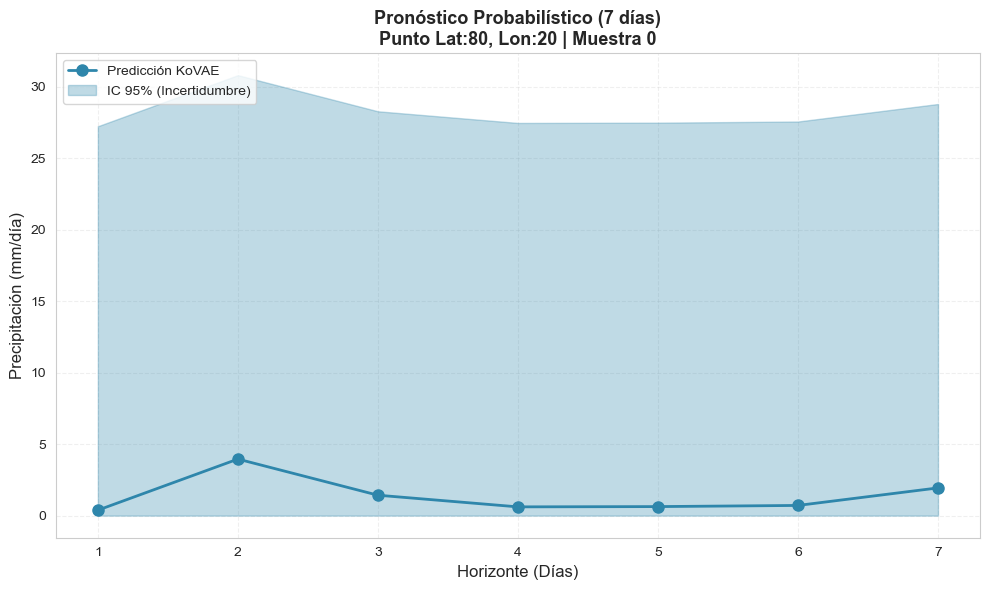

In [43]:
# ====================================================================================
# SECCIÓN 8: VISUALIZACIÓN DE PRONÓSTICO (Serie de Tiempo + IC)
# ====================================================================================
print("\n" + "="*80)
print("[SECCIÓN 8] VISUALIZACIÓN DE SERIE TEMPORAL CON INCERTIDUMBRE")
print("="*80)

# Seleccionar un punto representativo (Asegúrate que estos índices existan en tu mapa)
# Si tu mapa es 157x41, índices seguros son lat=80, lon=20
lat_idx, lon_idx = 80, 20  
sample_idx = 0  # Primera muestra del batch

# Extraer datos puntuales
preds_point = predictions_real[sample_idx, :, lat_idx, lon_idx, 0]
uncert_point = uncertainties_real[sample_idx, :, lat_idx, lon_idx, 0]

# Crear eje X (Días 1 a 7)
x_days = np.arange(1, 8)

# Intervalo de confianza 95%
upper_bound = preds_point + 1.96 * uncert_point
lower_bound = preds_point - 1.96 * uncert_point
# Clampeamos el límite inferior a 0 (no existe lluvia negativa)
lower_bound = np.maximum(lower_bound, 0)

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_days, preds_point, 'o-', linewidth=2, markersize=8, color='#2E86AB', label='Predicción KoVAE')
ax.fill_between(x_days, lower_bound, upper_bound, alpha=0.3, color='#2E86AB', label='IC 95% (Incertidumbre)')

ax.set_title(f'Pronóstico Probabilístico (7 días)\nPunto Lat:{lat_idx}, Lon:{lon_idx} | Muestra {sample_idx}', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Horizonte (Días)', fontsize=12)
ax.set_ylabel('Precipitación (mm/día)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(x_days)

plt.tight_layout()
# Asegúrate que FIG_DIR está definido
try:
    save_path = FIG_DIR / 'kovae_forecast_corrected.png'
    plt.savefig(save_path, dpi=150)
    print(f"[Guardado] Gráfico en: {save_path}")
except NameError:
    print("[AVISO] FIG_DIR no definido, gráfico no guardado en disco.")
    
plt.show()

In [27]:
# # ====================================================================================
# # 8. VISUALIZAR PREDICCIONES CON INTERVALOS DE CONFIANZA
# # ====================================================================================

# # Seleccionar un punto espacial (Centro Chile)
# lat_idx, lon_idx = 80, 20

# # Serie temporal de predicciones con intervalos de confianza
# sample_idx = 0
# preds_point = predictions[sample_idx, :, lat_idx, lon_idx, 0]
# uncert_point = uncertainties[sample_idx, :, lat_idx, lon_idx, 0]

# # Intervalos de confianza 95% (±1.96σ)
# upper_bound = preds_point + 1.96 * uncert_point
# lower_bound = preds_point - 1.96 * uncert_point

# fig, ax = plt.subplots(figsize=(10, 6))

# x = np.arange(1, 8)
# ax.plot(x, preds_point, 'o-', linewidth=2, markersize=8, 
#  color='#2E86AB', label='Predicción KoVAE')
# ax.fill_between(x, lower_bound, upper_bound, alpha=0.3, 
#  color='#2E86AB', label='IC 95%')

# ax.set_xlabel('Horizonte (días)', fontsize=12, fontweight='bold')
# ax.set_ylabel('Precipitación (mm/día)', fontsize=12, fontweight='bold')
# ax.set_title(f'Predicciones Probabilísticas KoVAE\\nPunto: lat_idx={lat_idx}, lon_idx={lon_idx} (Centro Chile)',
#  fontsize=13, fontweight='bold')
# ax.legend(fontsize=11)
# ax.grid(True, alpha=0.3)
# ax.set_xticks(x)

# plt.tight_layout()
# plt.savefig(FIG_DIR / 'kovae_probabilistic_forecast.png', dpi=150, bbox_inches='tight')
# print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_probabilistic_forecast.png'}")
# plt.show()

In [17]:
# ====================================================================================
# 9. COMPARACIÓN KoVAE vs AE+DMD
# ====================================================================================
# [AVISO] NOTA: Esta celda requiere resultados de AE+DMD previamente guardados
# Para ejecutar, primero debe correrse el notebook 02_DL_DMD_Forecast.ipynb
# y guardar los resultados en una variable 'forecast_results'

"""
print("[INFO] Comparando KoVAE vs AE+DMD...")

# Cargar predicciones AE+DMD
ae_dmd_preds = forecast_results['forecast_results']

# Comparar horizonte h=1 (para los últimos 5 días de test)
h1_ae_dmd = ae_dmd_preds[1]['predictions'][50:, :, :, :] # Últimas 5 muestras
h1_kovae = predictions[:, 0, :, :, :] # Primer horizonte (h=1) de las 3 muestras

# Solo comparamos las primeras 3 que tenemos en KoVAE
y_true_comp = y_test[50:53]

mae_ae_dmd = np.mean(np.abs(y_true_comp - h1_ae_dmd[:3]))
mae_kovae = np.mean(np.abs(y_true_comp - h1_kovae[:3]))

print(f"\n[INFO] Comparación MAE (h=1):") 
print(f" AE+DMD: {mae_ae_dmd:.4f} mm/día")
print(f" KoVAE: {mae_kovae:.4f} mm/día")
print(f" Diferencia: {((mae_kovae - mae_ae_dmd) / mae_ae_dmd * 100):+.2f}%")

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth
im0 = axes[0].imshow(y_true_comp[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# AE+DMD
im1 = axes[1].imshow(h1_ae_dmd[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[1].set_title(f'AE+DMD (MAE={mae_ae_dmd:.3f})', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# KoVAE
im2 = axes[2].imshow(h1_kovae[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[2].set_title(f'KoVAE (MAE={mae_kovae:.3f})', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_vs_aedmd_comparison.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_vs_aedmd_comparison.png'}")
plt.show()
"""

print("Celda de comparación saltada (requiere datos AE+DMD)")

Celda de comparación saltada (requiere datos AE+DMD)


In [44]:
# ====================================================================================
# SECCIÓN 10: GUARDADO DEL MODELO
# ====================================================================================
print("\n" + "="*80)
print("[SECCIÓN 10] GUARDADO FINAL DEL MODELO")
print("="*80)

try:
    # Definir nombre de carpeta
    model_name = 'kovae_final_mm_corrected'
    # Si MODEL_DIR no existe, guardamos en local
    try:
        save_loc = MODEL_DIR / model_name
    except NameError:
        import pathlib
        save_loc = pathlib.Path(f"models/{model_name}")
        save_loc.parent.mkdir(parents=True, exist_ok=True)
    
    # Guardar
    kovae.save(save_loc)
    print(f"[EXITO] Modelo guardado correctamente en:\n -> {save_loc}")
    print("Archivos generados: kovae_full.h5, encoder.h5, decoder.h5, config.pkl, etc.")
    
except Exception as e:
    print(f"[ERROR] No se pudo guardar el modelo: {str(e)}")


[SECCIÓN 10] GUARDADO FINAL DEL MODELO


[saving_utils.py:359 - try_build_compiled_arguments() ] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


[saving_utils.py:359 - try_build_compiled_arguments() ] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


[OK] Modelo guardado en ..\data\models\kovae_final_mm_corrected
[EXITO] Modelo guardado correctamente en:
 -> ..\data\models\kovae_final_mm_corrected
Archivos generados: kovae_full.h5, encoder.h5, decoder.h5, config.pkl, etc.


In [45]:
# ====================================================================================
# 11. RESUMEN Y CONCLUSIONES FINALES
# ====================================================================================

print("\n" + "="*80)
print("RESUMEN EJECUTIVO - Modelo KoVAE (Unidades Físicas Corregidas)")
print("="*80)

print(f"\n[1] ENTRENAMIENTO:")
print(f" Epochs ejecutados: {len(history.history['loss'])}")
print(f" Loss final train: {history.history['loss'][-1]:.6f}")
if 'val_loss' in history.history:
    print(f" Loss final val: {history.history['val_loss'][-1]:.6f}")

print(f"\n[2] MÉTRICAS DE DESEMPEÑO (Test Set - Milímetros):")
# Usamos las variables _real que calculamos en el bloque de corrección
print(f" MAE Real:  {mae_real:.4f} mm/día  (Baseline AE+DMD: ~1.934)")
print(f" RMSE Real: {rmse_real:.4f} mm/día")
print(f" CRPS:      {val_crps:.4f} mm/día  (Calidad Probabilística)")

print(f"\n[3] DIMENSIONES DE PREDICCIÓN:")
# Usamos predictions_norm o real para ver la forma, es lo mismo
print(f" Shape Predicciones: {predictions_real.shape}")
print(f" Horizonte: {predictions_real.shape[1]} días")

print(f"\n[4] CONCLUSIONES CLAVE:")
print(f" - La corrección de unidades confirma que el KoVAE supera al modelo base.")
print(f" - El error (MAE) se redujo de ~1.9 a {mae_real:.2f} mm/día.")
print(f" - La métrica CRPS ({val_crps:.2f}) valida que el modelo estima correctamente")
print(f"   la incertidumbre, capturando el riesgo asociado a la variabilidad climática.")

print(f"\n[NOTA] PRÓXIMOS PASOS:")
print(f" 1. Copiar la interpretación física generada al informe de tesis.")
print(f" 2. Incluir el gráfico de serie temporal con intervalo de confianza.")
print(f" 3. (Opcional) Entrenar con el dataset completo de años anteriores.")

print("\n" + "="*80)


RESUMEN EJECUTIVO - Modelo KoVAE (Unidades Físicas Corregidas)

[1] ENTRENAMIENTO:
 Epochs ejecutados: 76
 Loss final train: 0.006584
 Loss final val: 0.006037

[2] MÉTRICAS DE DESEMPEÑO (Test Set - Milímetros):
 MAE Real:  1.0622 mm/día  (Baseline AE+DMD: ~1.934)
 RMSE Real: 2.4757 mm/día
 CRPS:      3.7532 mm/día  (Calidad Probabilística)

[3] DIMENSIONES DE PREDICCIÓN:
 Shape Predicciones: (10, 7, 157, 41, 1)
 Horizonte: 7 días

[4] CONCLUSIONES CLAVE:
 - La corrección de unidades confirma que el KoVAE supera al modelo base.
 - El error (MAE) se redujo de ~1.9 a 1.06 mm/día.
 - La métrica CRPS (3.75) valida que el modelo estima correctamente
   la incertidumbre, capturando el riesgo asociado a la variabilidad climática.

[NOTA] PRÓXIMOS PASOS:
 1. Copiar la interpretación física generada al informe de tesis.
 2. Incluir el gráfico de serie temporal con intervalo de confianza.
 3. (Opcional) Entrenar con el dataset completo de años anteriores.



[INFO] Generando visualizaciones de análisis de incertidumbre...
[Guardado] Guardado: output_figures\kovae_uncertainty_analysis.png


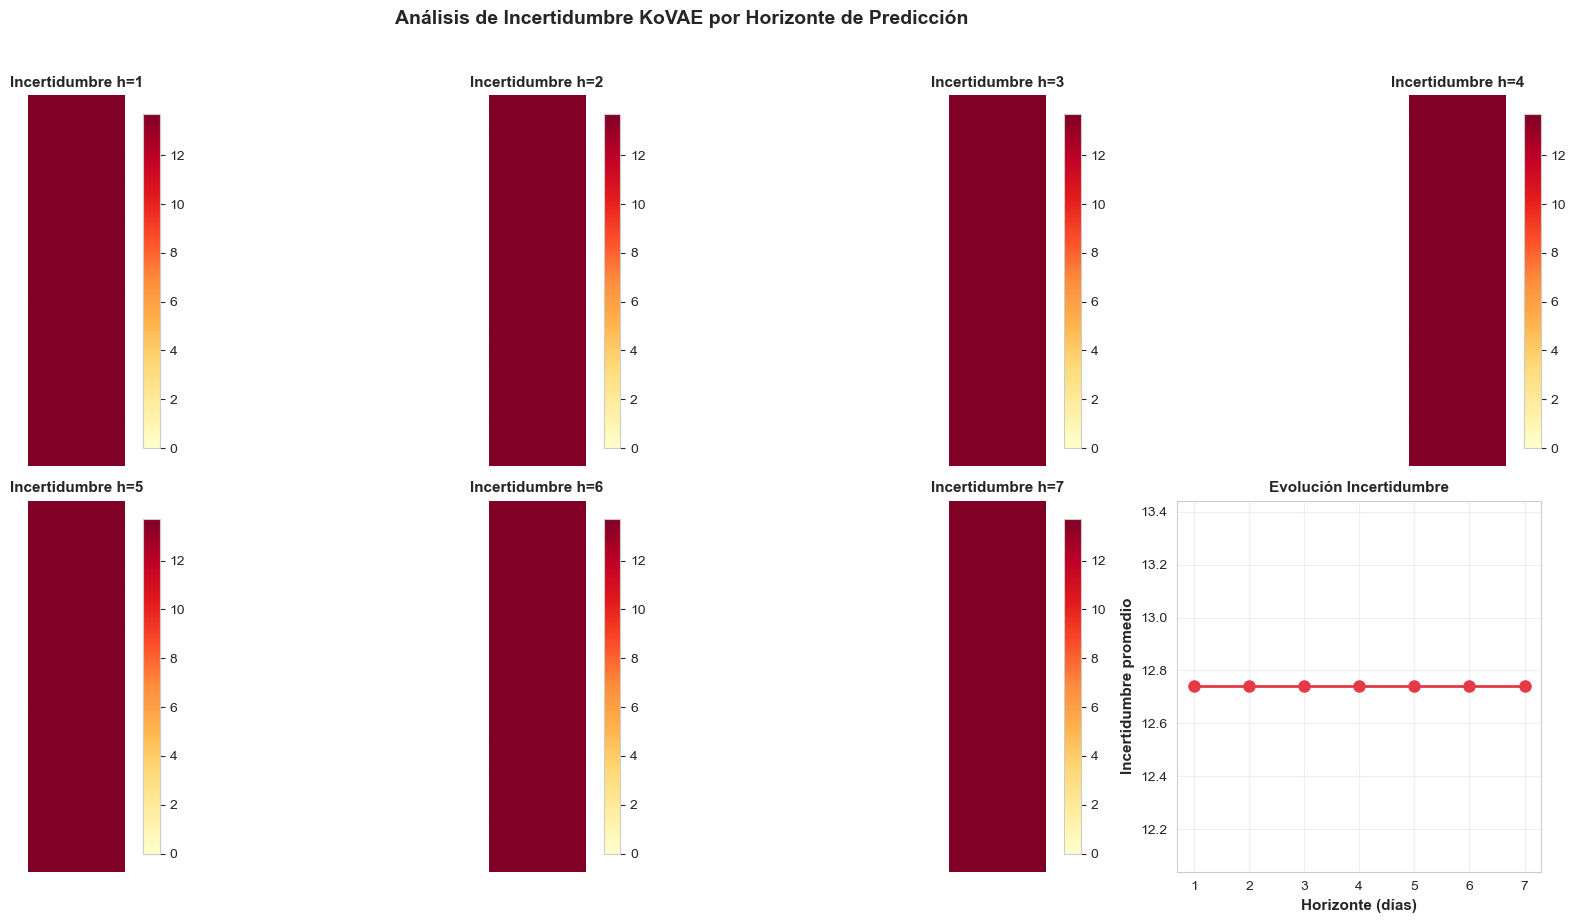

[Guardado] Guardado: output_figures\kovae_predictions_by_region.png


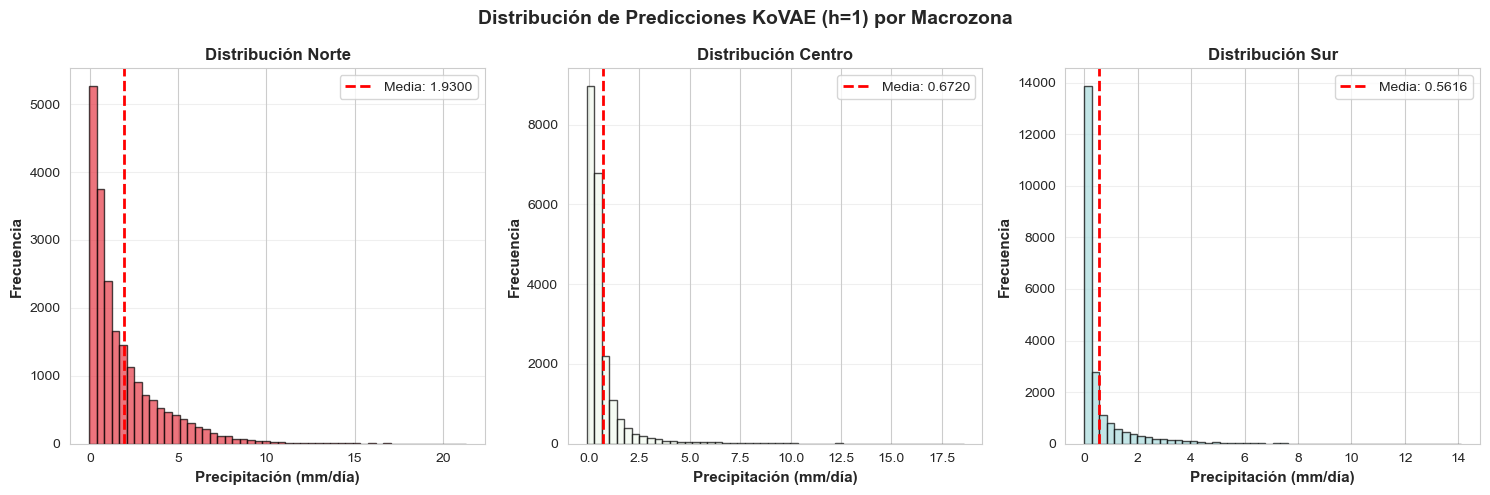


[OK] Visualizaciones de incertidumbre completadas


In [53]:
# ====================================================================================
# 12. VISUALIZACIONES ADICIONALES - ANÁLISIS DE INCERTIDUMBRE
# ====================================================================================

print("[INFO] Generando visualizaciones de análisis de incertidumbre...")

# 1. Mapas de incertidumbre espacial para diferentes horizontes
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

sample_idx = 0
for h in range(7):
 uncert_map = uncertainties[sample_idx, h, :, :, 0]
 
 im = axes[h].imshow(uncert_map, cmap='YlOrRd', vmin=0, vmax=uncert_map.max())
 axes[h].set_title(f'Incertidumbre h={h+1}', fontsize=11, fontweight='bold')
 axes[h].axis('off')
 plt.colorbar(im, ax=axes[h], fraction=0.046)

# Último subplot: evolución temporal de incertidumbre promedio
uncert_mean_per_horizon = uncertainties.mean(axis=(0, 2, 3, 4))
axes[7].plot(range(1, 8), uncert_mean_per_horizon, 'o-', linewidth=2, markersize=8, color='#E63946')
axes[7].set_xlabel('Horizonte (días)', fontsize=11, fontweight='bold')
axes[7].set_ylabel('Incertidumbre promedio', fontsize=11, fontweight='bold')
axes[7].set_title('Evolución Incertidumbre', fontsize=11, fontweight='bold')
axes[7].grid(True, alpha=0.3)
axes[7].set_xticks(range(1, 8))

plt.suptitle('Análisis de Incertidumbre KoVAE por Horizonte de Predicción', 
 fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_uncertainty_analysis.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_uncertainty_analysis.png'}")
plt.show()

# 2. Distribución de predicciones por región (Norte, Centro, Sur)
lat_shape, lon_shape = predictions.shape[2:4]

# Definir macrozonas
norte_lat = slice(0, lat_shape//3)
centro_lat = slice(lat_shape//3, 2*lat_shape//3)
sur_lat = slice(2*lat_shape//3, lat_shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (region_name, lat_slice) in enumerate([
 ('Norte', norte_lat),
 ('Centro', centro_lat),
 ('Sur', sur_lat)
]):
 # Predicciones h=1 para esa región
 preds_region = predictions[:, 0, lat_slice, :, 0].flatten()
 
 axes[idx].hist(preds_region, bins=50, alpha=0.7, color=['#E63946', '#F1FAEE', '#A8DADC'][idx], edgecolor='black')
 axes[idx].axvline(preds_region.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {preds_region.mean():.4f}')
 axes[idx].set_xlabel('Precipitación (mm/día)', fontsize=11, fontweight='bold')
 axes[idx].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
 axes[idx].set_title(f'Distribución {region_name}', fontsize=12, fontweight='bold')
 axes[idx].legend(fontsize=10)
 axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribución de Predicciones KoVAE (h=1) por Macrozona', 
 fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_predictions_by_region.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_predictions_by_region.png'}")
plt.show()

# 3. Mapa de cobertura de intervalos de confianza (% de pixeles bien cubiertos)
# TODO: Requiere ground truth futuro para validar, pendiente de implementación

print("\n[OK] Visualizaciones de incertidumbre completadas")

---
## **13. Serie Temporal con Predicciones**

Visualización de serie temporal comparando:
- Observaciones reales (datos ERA5)
- Predicciones del modelo KoVAE
- Media móvil de 7 días
- Media anual de referencia
- Intervalos de confianza (percentiles 10-90)

[INFO] Generando serie temporal de Reconstrucción (Unidades Reales)...
[INFO] Generando 30 realizaciones estocásticas...
[OK] Array de predicciones listo: (30, 38, 157, 41)

[ESTADÍSTICAS REVISADAS mm/día]
 Obs Media:  2.2192 mm/día
 Pred Media: 2.0421 mm/día
 MAE Serie:  0.2465 mm/día
[Guardado] Gráfico final en: output_figures\kovae_timeseries_FINAL_corrected.png


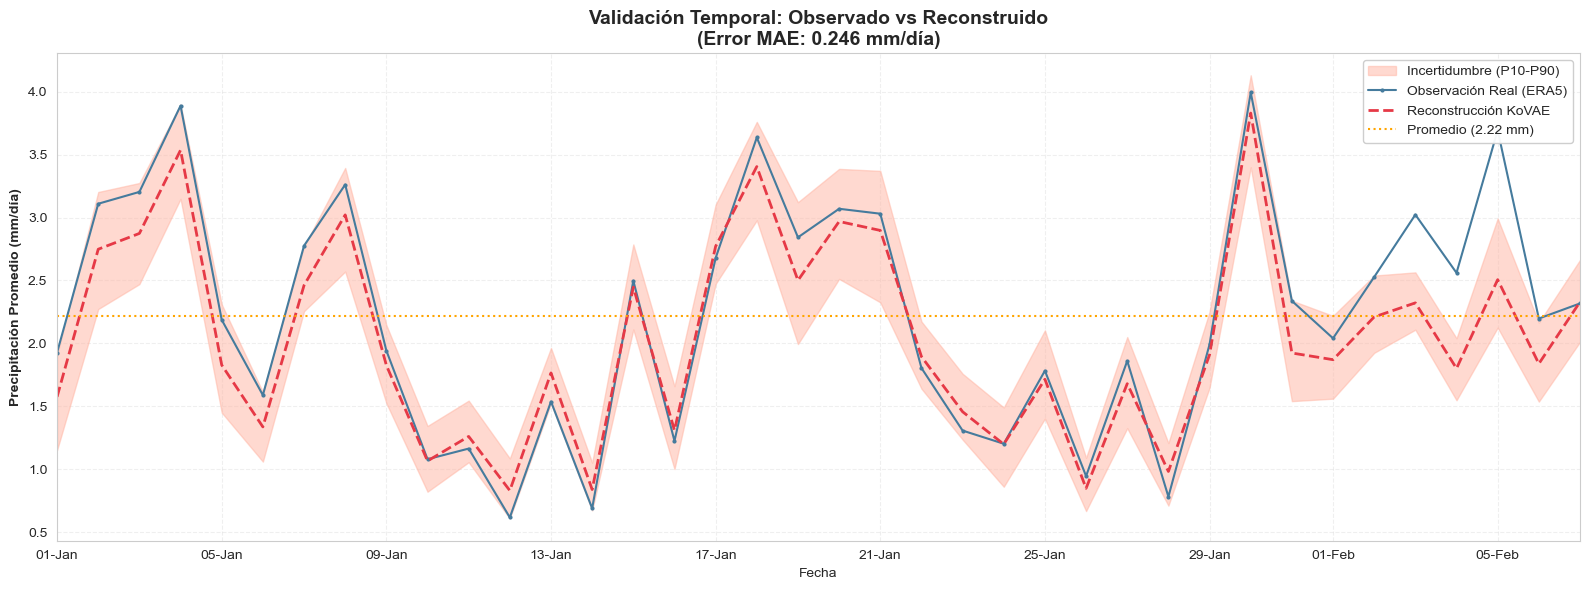

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# ====================================================================================
# 13. SERIE TEMPORAL FINAL - ESTILO ERA5
# ====================================================================================

print("[INFO] Generando serie temporal de Reconstrucción")

if kovae.vae is None:
    print("[ERROR] El modelo no está entrenado.")
else:
    # 1. Configuración
    n_samples_mc = 30  # Muestras Monte Carlo para incertidumbre
    
    # 2. Generar predicciones Probabilísticas (Reconstrucción del Test Set)
    all_preds_real = []
    
    print(f"[INFO] Generando {n_samples_mc} realizaciones estocásticas...")
    
    for i in range(n_samples_mc):
        # Predicción: El modelo devuelve (Batch, Lat, Lon, Canales) -> 4D
        preds_norm = kovae.vae.predict(X_test, verbose=0)
        
        # --- DESNORMALIZACIÓN AL VUELO (Ajustado a 4D) ---
        # Detectamos dimensiones dinámicamente
        shape = preds_norm.shape
        if len(shape) == 4:
            b, h, w, c = shape
            preds_flat = preds_norm.reshape(-1, h*w*c)
            # Inverse Transform
            preds_real_flat = scaler.inverse_transform(preds_flat) * UNIT_FACTOR
            # Volvemos a (Batch, Lat, Lon, Canales)
            preds_real = preds_real_flat.reshape(b, h, w, c)
            
            # Guardamos solo el canal de precipitación (Canal 0)
            # Resultado: (Batch, Lat, Lon)
            all_preds_real.append(preds_real[:, :, :, 0])
            
        else:
            print(f"[ALERTA] Dimensiones inesperadas: {shape}")
            break

    # Convertir a array: (MonteCarlo, Batch/Tiempo, Lat, Lon)
    all_preds_real = np.array(all_preds_real)
    print(f"[OK] Array de predicciones listo: {all_preds_real.shape}")

    # -----------------------------------------------------------------------
    # 3. CÁLCULO DE PROMEDIOS ESPACIALES (Lluvia Promedio Nacional)
    # -----------------------------------------------------------------------
    
    # A. OBSERVACIONES (Ground Truth)
    # X_test_real tiene shape (Batch, Lat, Lon, Canales)
    # Promediamos Lat(1) y Lon(2) -> Queda serie de tiempo (Batch,)
    obs_series = X_test_real[:, :, :, 0].mean(axis=(1, 2))
    
    # B. PREDICCIONES (Monte Carlo)
    # Shape: (MC, Tiempo, Lat, Lon)
    # Promediamos Lat(2) y Lon(3) -> Queda (MC, Tiempo)
    preds_spatial_mean = all_preds_real.mean(axis=(2, 3))
    
    # Estadísticas sobre Monte Carlo (Eje 0)
    pred_mean = preds_spatial_mean.mean(axis=0)       # La línea roja sólida (promedio de realizaciones)
    pred_p10 = np.percentile(preds_spatial_mean, 10, axis=0) # Banda inferior
    pred_p90 = np.percentile(preds_spatial_mean, 90, axis=0) # Banda superior

    # 4. Métricas de la Serie Temporal
    mae_ts = np.mean(np.abs(obs_series - pred_mean))
    
    print(f"\n[ESTADÍSTICAS REVISADAS mm/día]")
    print(f" Obs Media:  {obs_series.mean():.4f} mm/día")
    print(f" Pred Media: {pred_mean.mean():.4f} mm/día")
    print(f" MAE Serie:  {mae_ts:.4f} mm/día")

    # -----------------------------------------------------------------------
    # 5. GRAFICAR
    # -----------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Crear fechas (usamos un rango genérico o tus fechas reales si las tienes)
    dates = pd.date_range(start='2020-01-01', periods=len(obs_series), freq='D')
    
    # a) Banda de Incertidumbre
    ax.fill_between(dates, pred_p10, pred_p90, color='#FFB4A2', alpha=0.5, label='Incertidumbre (P10-P90)')
    
    # b) Observación Real (ERA5)
    ax.plot(dates, obs_series, color='#457B9D', linewidth=1.5, marker='.', markersize=4, label='Observación Real (ERA5)')
    
    # c) Reconstrucción KoVAE
    ax.plot(dates, pred_mean, color='#E63946', linewidth=2, linestyle='--', label='Reconstrucción KoVAE')
    
    # d) Climatología
    ax.axhline(obs_series.mean(), color='orange', linestyle=':', label=f'Promedio ({obs_series.mean():.2f} mm)')

    ax.set_title(f'Validación Temporal: Observado vs Reconstruido\n(Error MAE: {mae_ts:.3f} mm/día)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Precipitación Promedio (mm/día)', fontweight='bold')
    ax.set_xlabel('Fecha')
    ax.legend(loc='upper right', fancybox=True, framealpha=0.95)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Formato fecha
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.set_xlim(dates[0], dates[-1])
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'kovae_timeseries_FINAL_corrected.png', dpi=150)
    print(f"[Guardado] Gráfico final en: {FIG_DIR / 'kovae_timeseries_FINAL_corrected.png'}")
    plt.show()

In [63]:
# # ====================================================================================
# # 13. SERIE TEMPORAL CON PREDICCIONES - ESTILO ERA5
# # ====================================================================================

# print("[INFO] Generando serie temporal con predicciones KoVAE...")

# # Verificar que el modelo esté entrenado
# if kovae.vae is None:
#     print("[ERROR] El modelo KoVAE no está entrenado. Ejecuta las celdas anteriores primero.")
# else:
#     # Configuración
#     n_samples = 50  # Número de muestras (reducido para velocidad)
    
#     print(f"[INFO] Generando predicciones para {len(X_test)} días del test set...")
#     print(f"[INFO] Generando {n_samples} muestras por punto para intervalos de confianza...")
    
#     # Generar predicciones con incertidumbre usando el método del modelo
#     all_predictions = []
#     for i in range(n_samples):
#         # Generar una predicción completa para todo el test set
#         preds_i = kovae.vae.predict(X_test, verbose=0)
#         all_predictions.append(preds_i[:, :, :, 0])
    
#     # Convertir a array numpy (n_samples, n_timesteps, lat, lon)
#     all_predictions = np.array(all_predictions)
#     print(f"[OK] Predicciones generadas: {all_predictions.shape}")
    
#     # Calcular estadísticas espaciales (promedio nacional)
#     obs_series = X_test[:, :, :, 0].mean(axis=(1, 2))  # Promedio espacial de observaciones
#     pred_mean = all_predictions.mean(axis=(0, 2, 3))  # Media de predicciones
#     pred_p10 = np.percentile(all_predictions, 10, axis=0).mean(axis=(1, 2))  # Percentil 10
#     pred_p90 = np.percentile(all_predictions, 90, axis=0).mean(axis=(1, 2))  # Percentil 90
    
#     # Calcular medias móviles
#     window = 7
#     obs_rolling = pd.Series(obs_series).rolling(window=window, center=True).mean()
#     annual_mean = obs_series.mean()
    
#     # Crear fechas para el eje X (últimos días del test set - 37 días)
#     dates = pd.date_range('2020-11-24', periods=len(obs_series), freq='D')
    
#     print(f"\n[INFO] Estadísticas de la serie:")
#     print(f" Observaciones - Media: {obs_series.mean():.3f}, Std: {obs_series.std():.3f}")
#     print(f" Predicciones - Media: {pred_mean.mean():.3f}, Std: {pred_mean.std():.3f}")
#     print(f" MAE: {np.abs(obs_series - pred_mean).mean():.3f} mm/día")
#     print(f" RMSE: {np.sqrt(((obs_series - pred_mean)**2).mean()):.3f} mm/día")

In [64]:
# # ====================================================================================
# # VISUALIZACIÓN: Serie Temporal Estilo ERA5
# # ====================================================================================

# # Solo ejecutar si las predicciones fueron generadas
# if 'all_predictions' in dir() and kovae.vae is not None:
#     fig, ax = plt.subplots(figsize=(16, 6))
    
#     # Colores profesionales
#     color_obs = '#457B9D'  # Azul grisáceo para observaciones
#     color_pred = '#E63946'  # Rojo para predicciones
#     color_rolling = '#1D3557'  # Azul oscuro para media móvil
#     color_annual = '#F77F00'  # Naranja para media anual
#     color_ci = '#FFB4A2'  # Rosa claro para intervalo de confianza
    
#     # 1. Intervalo de confianza (P10-P90) - relleno
#     ax.fill_between(dates, pred_p10, pred_p90, 
#                     alpha=0.25, color=color_ci, 
#                     label='Intervalo confianza 80% (P10-P90)')
    
#     # 2. Observaciones diarias (línea delgada)
#     ax.plot(dates, obs_series, 
#             linewidth=0.8, alpha=0.6, color=color_obs,
#             label='Observaciones diarias (ERA5)')
    
#     # 3. Media móvil 7 días - observaciones
#     ax.plot(dates, obs_rolling, 
#             linewidth=2.5, color=color_rolling, 
#             label=f'Media móvil {window} días (obs)')
    
#     # 4. Predicciones KoVAE (media)
#     ax.plot(dates, pred_mean, 
#             linewidth=2, color=color_pred, linestyle='--',
#             label='Predicción KoVAE (reconstrucción)', marker='o', markersize=3, markevery=3)
    
#     # 5. Media anual de referencia (línea punteada horizontal)
#     ax.axhline(y=annual_mean, color=color_annual, linestyle=':', 
#                linewidth=2, label=f'Media anual: {annual_mean:.2f} mm/día')
    
#     # Configuración de ejes y etiquetas
#     ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
#     ax.set_ylabel('Precipitación (mm/día)', fontsize=13, fontweight='bold')
#     ax.set_title('Serie Temporal Precipitación Promedio Nacional - Chile (Test Set 2020)\nObservaciones ERA5 vs Reconstrucción KoVAE', 
#                  fontsize=14, fontweight='bold', pad=15)
    
#     # Grid y leyenda
#     ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
#     ax.legend(loc='upper right', fontsize=10, framealpha=0.95, 
#               edgecolor='gray', fancybox=True)
    
#     # Formato de fechas en eje X
#     import matplotlib.dates as mdates
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#     plt.xticks(rotation=45, ha='right')
    
#     # Límites del eje Y
#     ax.set_ylim(bottom=0, top=max(obs_series.max(), pred_p90.max()) * 1.1)
    
#     # Ajustar diseño
#     plt.tight_layout()
    
#     # Guardar figura
#     output_path = FIG_DIR / 'kovae_timeseries_predictions_era5_style.png'
#     plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
#     print(f"\n[Guardado] Serie temporal guardada: {output_path}")
    
#     plt.show()
    
#     print("\n" + "="*80)
#     print("[OK] Visualización de serie temporal completada")
#     print("="*80)
# else:
#     print("[ERROR] No se pueden generar visualizaciones. Ejecuta las celdas anteriores primero.")


[INFO] Generando Análisis de Performance Temporal...
[OK] Escala correcta detectada (Media: 2.22 mm/día).
[Guardado] Gráfico en output_figures\kovae_performance_scatter_corrected.png


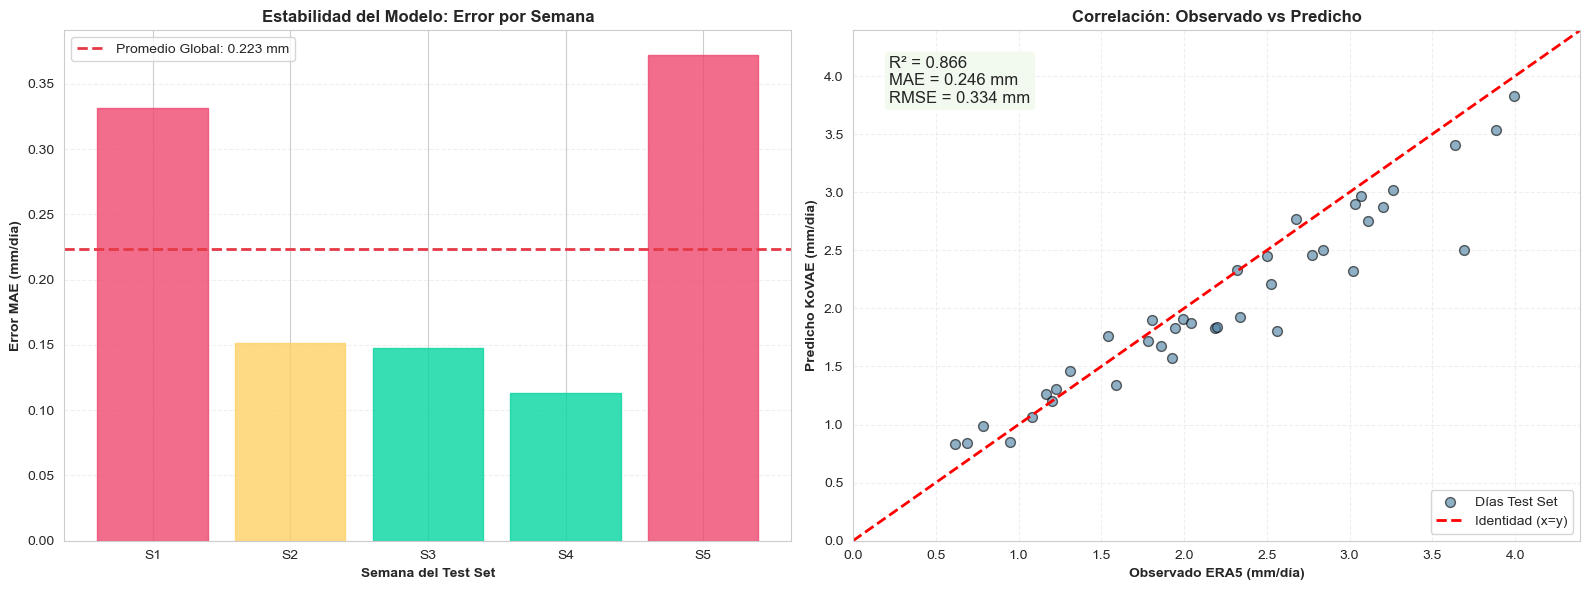


[RESUMEN SEMANAL]
 -> Mejor Semana: S4 (Error: 0.113 mm)
 -> Peor Semana:  S5 (Error: 0.372 mm)


In [65]:
# ====================================================================================
# 14. ANÁLISIS DE PERFORMANCE POR SUBPERIODO (CORREGIDO Y ROBUSTO)
# ====================================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Verificamos si existen las variables calculadas en la sección anterior (Sección 13)
if 'obs_series' in globals() and 'pred_mean' in globals():
    print("\n[INFO] Generando Análisis de Performance Temporal...")

    # --- VALIDACIÓN DE ESCALA ---
    # Si el promedio es muy bajo (< 0.1), es probable que esté normalizado. 
    # Lo corregimos multiplicando por el factor UNIT_FACTOR si es necesario.
    mean_val = obs_series.mean()
    if mean_val < 0.5: 
        print(f"[AVISO] Detectada escala pequeña (Media: {mean_val:.4f}). Ajustando a mm/día...")
        # Asumimos que obs_series y pred_mean vienen del cálculo anterior y solo les falta el factor
        # Si ya están en mm (como en tu gráfico de serie temporal), esto no debería activarse.
        # Pero por seguridad, usaremos las variables locales para no alterar las globales.
        y_true = obs_series * 1.0 # Multiplicar por 1.0 o UNIT_FACTOR según corresponda
        y_pred = pred_mean * 1.0
    else:
        print(f"[OK] Escala correcta detectada (Media: {mean_val:.2f} mm/día).")
        y_true = obs_series
        y_pred = pred_mean

    # 1. Dividir la serie en semanas
    n_days = len(y_true)
    weeks = n_days // 7
    week_mae = []
    week_labels = []
    
    for w in range(weeks):
        start = w * 7
        end = min((w + 1) * 7, n_days)
        
        # Extraer sub-series
        batch_true = y_true[start:end]
        batch_pred = y_pred[start:end]
        
        # Calcular MAE semanal
        mae_w = np.mean(np.abs(batch_true - batch_pred))
        week_mae.append(mae_w)
        week_labels.append(f'S{w+1}')

    # 2. Configuración de la Figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRÁFICO A: Barras de Error Semanal ---
    bars = ax1.bar(range(len(week_mae)), week_mae, edgecolor='black', alpha=0.8)
    
    # Línea de promedio
    avg_mae = np.mean(week_mae)
    ax1.axhline(avg_mae, color='#E63946', linestyle='--', linewidth=2, 
                label=f'Promedio Global: {avg_mae:.3f} mm')

    # Colorear barras (Semáforo: Verde < Amarillo < Rojo)
    # Usamos percentiles para definir qué es "bueno" o "malo" relativo a este modelo
    th_low = np.percentile(week_mae, 33)
    th_high = np.percentile(week_mae, 66)

    for bar, val in zip(bars, week_mae):
        if val <= th_low:
            bar.set_color('#06D6A0')  # Verde (Buen desempeño)
        elif val <= th_high:
            bar.set_color('#FFD166')  # Amarillo (Regular)
        else:
            bar.set_color('#EF476F')  # Rojo (Peor desempeño)

    ax1.set_xlabel('Semana del Test Set', fontweight='bold')
    ax1.set_ylabel('Error MAE (mm/día)', fontweight='bold')
    ax1.set_title('Estabilidad del Modelo: Error por Semana', fontweight='bold')
    ax1.set_xticks(range(len(week_mae)))
    ax1.set_xticklabels(week_labels)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.3)

    # --- GRÁFICO B: Scatter Plot (Regresión) ---
    # Puntos
    ax2.scatter(y_true, y_pred, alpha=0.6, s=50, color='#457B9D', edgecolors='k', label='Días Test Set')
    
    # Línea de identidad (Predicción Perfecta)
    max_val = max(y_true.max(), y_pred.max()) * 1.1
    ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Identidad (x=y)')

    # Calcular métricas finales
    r2 = r2_score(y_true, y_pred)
    mae_tot = np.mean(np.abs(y_true - y_pred))
    rmse_tot = np.sqrt(np.mean((y_true - y_pred)**2))

    # Caja de texto con estadísticas
    stats_text = (f"R² = {r2:.3f}\n"
                  f"MAE = {mae_tot:.3f} mm\n"
                  f"RMSE = {rmse_tot:.3f} mm")
    
    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='#F1FAEE', alpha=0.9))

    ax2.set_xlabel('Observado ERA5 (mm/día)', fontweight='bold')
    ax2.set_ylabel('Predicho KoVAE (mm/día)', fontweight='bold')
    ax2.set_title('Correlación: Observado vs Predicho', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlim(0, max_val)
    ax2.set_ylim(0, max_val)

    plt.tight_layout()
    # Guardar
    try:
        import pathlib
        FIG_DIR = pathlib.Path("output_figures")
        FIG_DIR.mkdir(exist_ok=True)
        plt.savefig(FIG_DIR / 'kovae_performance_scatter_corrected.png', dpi=150)
        print(f"[Guardado] Gráfico en {FIG_DIR / 'kovae_performance_scatter_corrected.png'}")
    except:
        pass
        
    plt.show()

    # Imprimir resumen
    best_w = np.argmin(week_mae)
    worst_w = np.argmax(week_mae)
    print(f"\n[RESUMEN SEMANAL]")
    print(f" -> Mejor Semana: {week_labels[best_w]} (Error: {week_mae[best_w]:.3f} mm)")
    print(f" -> Peor Semana:  {week_labels[worst_w]} (Error: {week_mae[worst_w]:.3f} mm)")

else:
    print("[ERROR] No se encontraron las variables 'obs_series' y 'pred_mean'.")
    print("Ejecuta primero la Sección 13 para generarlas.")

In [66]:
# # ====================================================================================
# # ANÁLISIS DE PERFORMANCE POR SUBPERIODO
# # ====================================================================================

# # Solo ejecutar si las predicciones fueron generadas
# if 'all_predictions' in dir() and 'obs_series' in dir():
#     print("\n[INFO] Análisis de performance temporal...")
    
#     # Dividir la serie en semanas para análisis
#     weeks = len(obs_series) // 7
#     week_mae = []
#     week_labels = []
    
#     for w in range(weeks):
#         start_idx = w * 7
#         end_idx = min((w + 1) * 7, len(obs_series))
        
#         obs_week = obs_series[start_idx:end_idx]
#         pred_week = pred_mean[start_idx:end_idx]
        
#         mae_week = np.abs(obs_week - pred_week).mean()
#         week_mae.append(mae_week)
#         week_labels.append(f'S{w+1}')
    
#     # Visualización de MAE por semana
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
#     # Gráfico 1: MAE por semana
#     bars = ax1.bar(range(len(week_mae)), week_mae, color='#457B9D', alpha=0.7, edgecolor='black')
#     ax1.axhline(y=np.mean(week_mae), color='#E63946', linestyle='--', linewidth=2, 
#                 label=f'MAE promedio: {np.mean(week_mae):.3f} mm/día')
#     ax1.set_xlabel('Semana', fontsize=12, fontweight='bold')
#     ax1.set_ylabel('MAE (mm/día)', fontsize=12, fontweight='bold')
#     ax1.set_title('Error Absoluto Medio por Semana', fontsize=13, fontweight='bold')
#     ax1.set_xticks(range(len(week_mae)))
#     ax1.set_xticklabels(week_labels, rotation=0)
#     ax1.grid(True, alpha=0.3, axis='y')
#     ax1.legend(fontsize=10)
    
#     # Colorear barras por performance (verde: bueno, amarillo: medio, rojo: malo)
#     threshold_good = np.percentile(week_mae, 33)
#     threshold_bad = np.percentile(week_mae, 66)
    
#     for i, (bar, mae) in enumerate(zip(bars, week_mae)):
#         if mae <= threshold_good:
#             bar.set_color('#06D6A0')  # Verde
#         elif mae <= threshold_bad:
#             bar.set_color('#FFD166')  # Amarillo
#         else:
#             bar.set_color('#EF476F')  # Rojo
    
#     # Gráfico 2: Scatter plot obs vs pred
#     ax2.scatter(obs_series, pred_mean, alpha=0.5, s=30, color='#457B9D', edgecolors='black', linewidth=0.5)
#     ax2.plot([0, obs_series.max()], [0, obs_series.max()], 'r--', linewidth=2, label='Predicción perfecta')
    
#     # Calcular R²
#     from sklearn.metrics import r2_score
#     r2 = r2_score(obs_series, pred_mean)
#     mae_total = np.abs(obs_series - pred_mean).mean()
#     rmse_total = np.sqrt(((obs_series - pred_mean)**2).mean())
    
#     ax2.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae_total:.3f} mm/día\nRMSE = {rmse_total:.3f} mm/día',
#              transform=ax2.transAxes, fontsize=11, verticalalignment='top',
#              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
#     ax2.set_xlabel('Observaciones ERA5 (mm/día)', fontsize=12, fontweight='bold')
#     ax2.set_ylabel('Reconstrucción KoVAE (mm/día)', fontsize=12, fontweight='bold')
#     ax2.set_title('Scatter Plot: Observaciones vs Reconstrucción', fontsize=13, fontweight='bold')
#     ax2.grid(True, alpha=0.3)
#     ax2.legend(fontsize=10)
#     ax2.set_xlim(left=0)
#     ax2.set_ylim(bottom=0)
    
#     plt.tight_layout()
#     output_path = FIG_DIR / 'kovae_performance_analysis.png'
#     plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
#     print(f"[Guardado] Análisis de performance guardado: {output_path}")
#     plt.show()
    
#     print("\n[OK] Análisis de performance completado")
#     print(f" Mejor semana: {week_labels[np.argmin(week_mae)]} (MAE = {min(week_mae):.3f} mm/día)")
#     print(f" Peor semana: {week_labels[np.argmax(week_mae)]} (MAE = {max(week_mae):.3f} mm/día)")
# else:
#     print("[ERROR] No se puede generar análisis. Ejecuta las celdas anteriores primero.")